# Workshop Tutorial: Detrending Photometry Time Series

One of the fundamental issues in computational modeling in general, and fitting lightcurve data in particular, is the presence of unknown trends in the data. These trends can be instrumental (for example, spatially and/or temporally varying detector sensitivity, pointing/tracking accuracy, electronic cross-talk, reduction anomalies, etc.), observational (atmospheric scintillation, variable cloud coverage, stray light, background light contamination, etc.) or astrophysical (stellar surface prominences, pulsations, extraneous body interactions, interstellar scattering, etc.).

In terms of light contribution, trends can be additive, multiplicative, a combination of two, or something else entirely. As a rule of thumb, anything astrophysical that is tied to the observed system itself will likely be multiplicative and anything extraneous to the system will be additive. In terms of systematics, errors that scale with the amount of light will be multiplicative while errors from the instrument itself will be additive. This distinction is crucial; we _assume_ the type of trend based on any prior information that we have, but ultimately this is guesswork. The only proper way to account for trends and systematics is to formulate a parametrized noise model and include it in the fitting proceess.

In this tutorial we will take a TESS lightcurve and treat the trend as purely multiplicative; in other words, we will model it and then _divide_ it out of the data in the hope that the leftover signal is a reasonable approximation for the underlying astrophysical signal of the binary.

While we recommend using a noise model or Gaussian processes to model the noise when applying mcmc, for estimators and optimizers, it is necessary to remove these trends to arrive at an initial model. Here we will demonstrate a strawman's approach to detrending, which we recomend for the initial stagest of detrending.

To begin, let us import numpy and pyplot:

In [19]:
import numpy as np
import matplotlib.pyplot as plt

Now we need to make sure the plots look a little nicer. If you are running this notebook from the cloned github repo, you can use the included mplstyle; if not, we will set mpl properties manually:

In [20]:
try:
    plt.style.use('./jupyter.mplstyle')
except:
    import matplotlib as mpl
    mpl.rcParams['figure.figsize'] = 16, 6
    mpl.rcParams['font.sans-serif'] = 'Arial, Liberation Sans, DejaVu Sans, Bitstream Vera Sans, sans-serif'
    mpl.rcParams['font.family'] = 'sans-serif'
    mpl.rcParams['font.size'] = 16

Next, we load a TESS lightcurve of [TIC 91961](http://tessEBs.villanova.edu/91961). Here is the [data file](https://github.com/phoebe-project/phoebe2-workshop/blob/2022june/data/noise_examples/tic91961.lc) if you need it. Let's take a look at what we're working with:

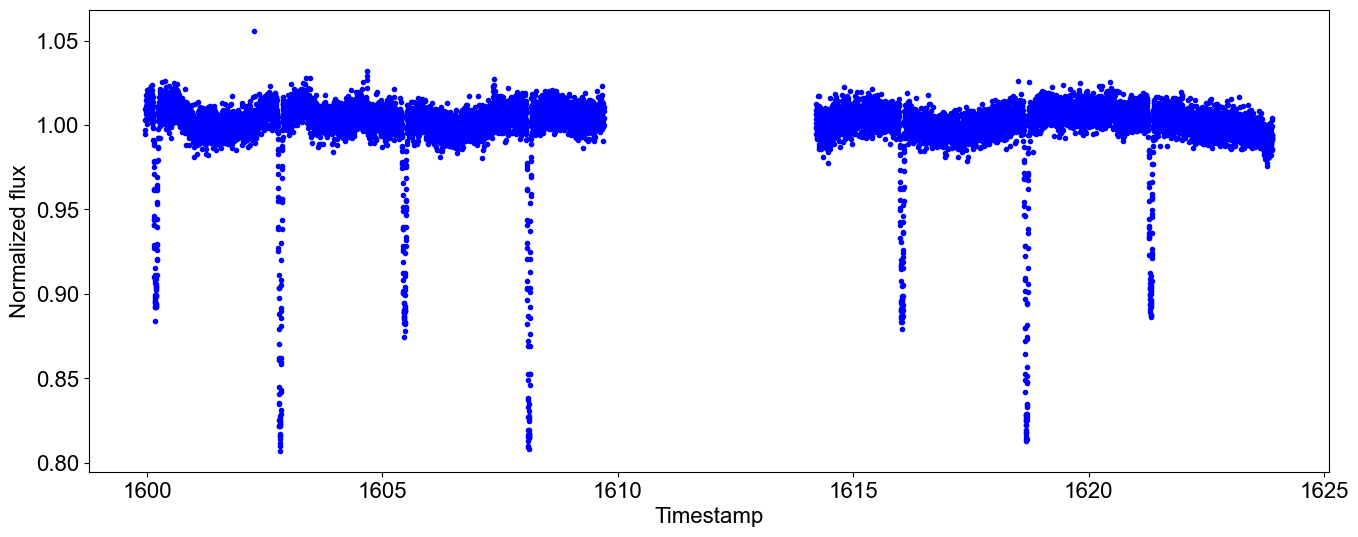

In [21]:
data = np.loadtxt('data/noise_examples/tic91961.lc')

plt.xlabel('Timestamp')
plt.ylabel('Normalized flux')
plt.plot(data[:,0], data[:,1], 'b.')

The resulting light curve has already been normalized by dividing by the median flux value. This should be done on a per-sector (or quarter) basis.

The idea here is to try and remove the baseline variation; whether this variation is caused by instrumental, observational or astrophysical circumstances is largely irrelevant (beyond any introspection to the type of stipulated noise, i.e. additive or multiplicative).

One of the simplest approaches might be to decompose the lightcurve into a suitable orthogonal basis, such as Legendre polynomials. Eclipses are obviously making this more difficult, so instead of just fitting the entire timeseries, we will remove any obvious non-trend parts of the lightcurve (i.e. eclipses) by sigma-clipping.

Legendre polynomials are best behaved on the unit interval, so we start by renormalizing the temporal axis of our dataset:

In [22]:
tmin, tmax = data[:,0][0], data[:,0][-1]
data[:,0] = (data[:,0]-tmin)/(tmax-tmin)

Once that is done, we need to parametrize our baseline. As stated above, we will use the Legendre series:

$$ y(t) = \sum_{k=0}^{N} c_k P_k(t), $$

where $y(t)$ is the normalized flux, $P_k$ are Legendre polynomials of the $k$-th order, and $c_k$ are the corresponding coefficients that we obtain from ordinary (linear) least squares fitting.

Next, we need to cull parts of the timeseries that have nothing to do with trend. To that end, we will first calculate standard deviation $\sigma$ of the dataset and use that as the overall scale for our sigma-clipping algorithm, aptly denoted `initial_sigma` in the code below. Then we need the highest Legendre polynomial order $N$ (denoted with `order`), and upper and lower intervals $\xi_\mathrm{hi}$ and $\xi_\mathrm{lo}$ for data culling (denoted `xi_hi` and `xi_lo`, respectively). Given the timeseries, $\sigma$, $N$, $\xi_\mathrm{lo}$ and $\xi_\mathrm{hi}$, we:

* fit a Legendre series to the entire timeseries to obtain an initial baseline $b(t)$;
* cull all datapoints that fall outside the $y(t)-b(t) \in [-\xi_\mathrm{lo} \sigma, \xi_\mathrm{hi} \sigma]$;
* refit a Legendre series to the remaining datapoints and repeat the procedure until no points are culled.

These parameters are user-provided, so it takes a bit of trial-and-error to figure out reasonable values. Let's start with something that makes sense and we'll refine it later.

In [41]:
initial_sigma = np.std(data[:,1])
order = 20
xi_hi = 2
xi_lo = 0.5

Now we fit the Legendre series and use the coefficients to compute the baseline:

In [42]:
coeffs = np.polynomial.legendre.legfit(data[:,0], data[:,1], order, w=data[:,2])
baseline = np.polynomial.legendre.legval(data[:,0], coeffs, tensor=False)

/usr/local/lib/python3.10/site-packages/numpy/polynomial/legendre.py:1412: RankWarning: The fit may be poorly conditioned
  return pu._fit(legvander, x, y, deg, rcond, full, w)


Now we filter out the outliers given our sigma low and high values:

In [43]:
flt = (data[:,1]-baseline < xi_hi*initial_sigma) & (data[:,1]-baseline > -xi_lo*initial_sigma)

Let's take a look at what that looks like: the data, the baseline, and the remaining datapoints:

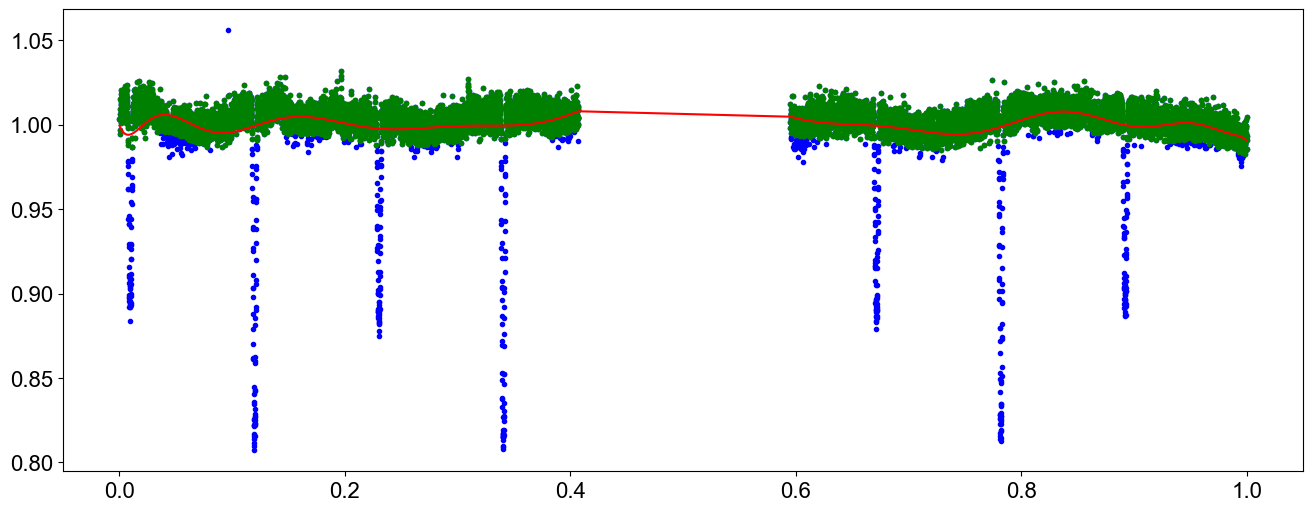

In [44]:
plt.plot(data[:,0], data[:,1], 'b.')
plt.plot(data[:,0][flt], data[:,1][flt], 'g.')
plt.plot(data[:,0], baseline, 'r-')
plt.show()

Let's see how many points we removed:

In [45]:
culled_data = data[flt]
culled_points = len(data)-len(culled_data)
print(f'{culled_points} datapoints culled')

747 datapoints culled


This looks like a reasonable first step. Now let's refit the baseline to the lightcurve with the points removed (culled), cull again, and refit (iteratively) until no more datapoints are culled:

In [46]:
while culled_points > 0:
    coeffs = np.polynomial.legendre.legfit(culled_data[:,0], culled_data[:,1], 10, w=culled_data[:,2])
    baseline = np.polynomial.legendre.legval(culled_data[:,0], coeffs, tensor=False)
    flt = (culled_data[:,1]-baseline < xi_hi*initial_sigma) & (culled_data[:,1]-baseline > -xi_lo*initial_sigma)
    culled_points = len(culled_data)-len(culled_data[flt])
    culled_data = culled_data[flt]
    print(f'{culled_points} datapoints culled')

421 datapoints culled
101 datapoints culled
22 datapoints culled
12 datapoints culled
3 datapoints culled
4 datapoints culled
2 datapoints culled
0 datapoints culled


Plot the converged fit:

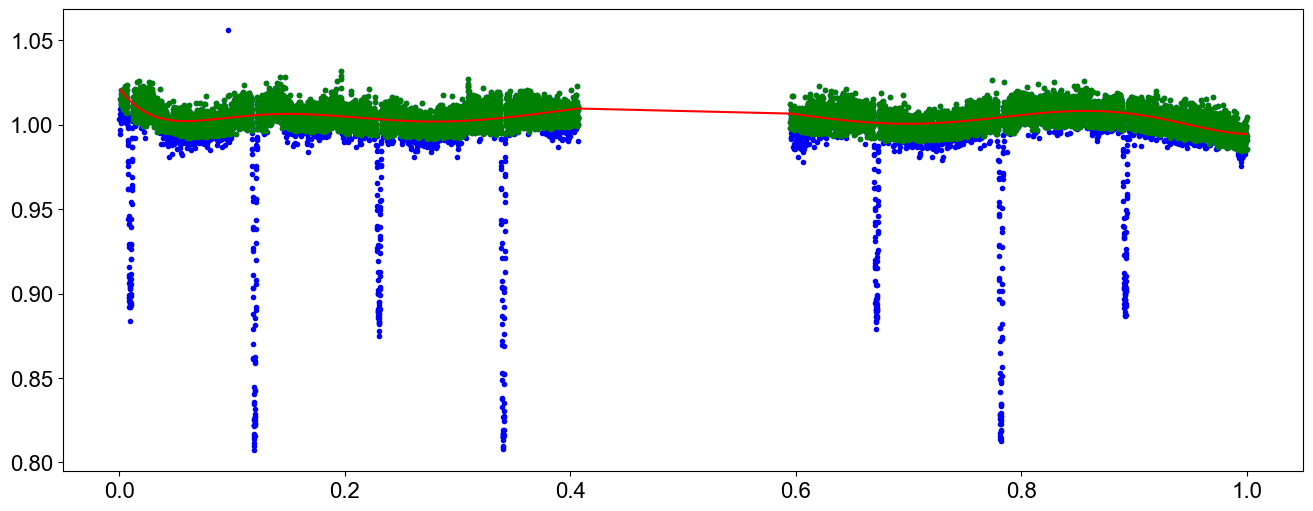

In [47]:
plt.plot(data[:,0], data[:,1], 'b.')
plt.plot(culled_data[:,0], culled_data[:,1], 'g.')
plt.plot(culled_data[:,0], baseline, 'r-')
plt.show()

The baseline is our approximation for the trend. One final step is to divide the data by the baseline (i.e., detrend the data) and rescale the temporal axis back:

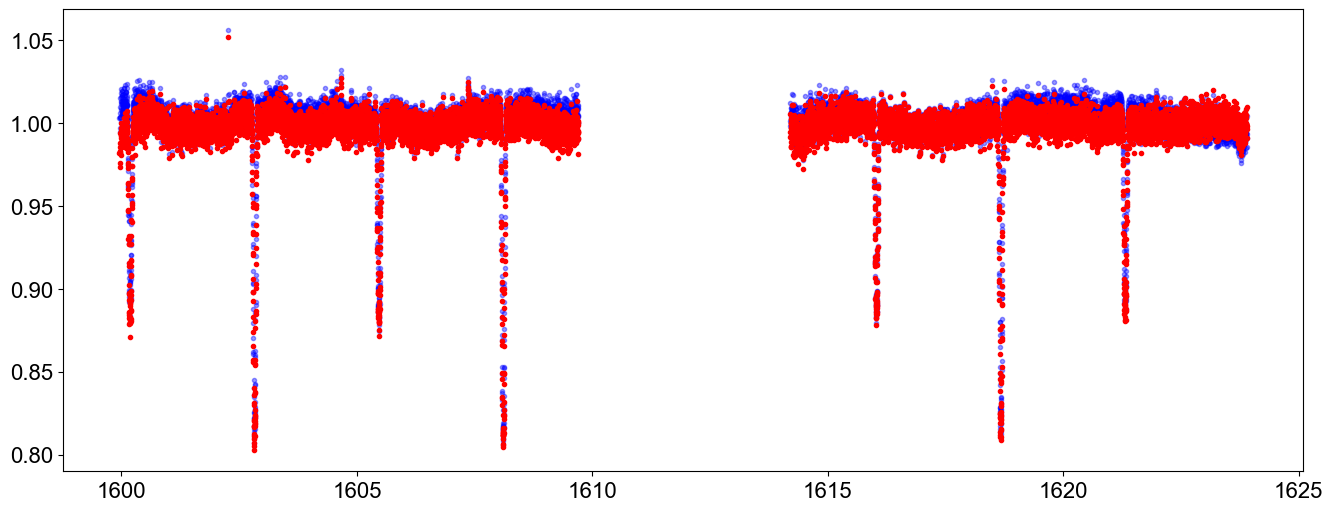

In [40]:
times = tmin + data[:,0]*(tmax-tmin)
detrended_timeseries = data[:,1]/np.polynomial.legendre.legval(data[:,0], coeffs, tensor=False)
plt.plot(times, data[:,1], 'b.',alpha=0.4)
plt.plot(times, detrended_timeseries, 'r.')
plt.show()

This is certainly better than it was initially, but remaining trends are still quite obvious. One aspect worth checking is the distribution of the residuals about the fitted baseline:

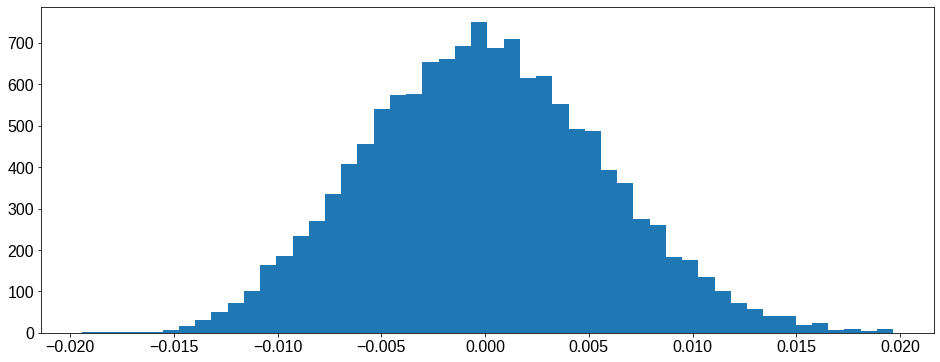

In [12]:
_ = plt.hist(culled_data[:,1]-baseline, bins=50)

This tells us that, _overall_, the residuals are (largely) normally distributed. What we need in addition is to assess the presence of _serial correlation_ in the residuals: if there is no serial correlation, then the distribution of the residuals is consistent with a normal distribution. While there are formal tests that deal with this question (such as [Durbin-Watson](https://www.statisticshowto.com/durbin-watson-test-coefficient/) test for linear regression problems), we will implement our own here to gain better insight.

Let's start by plotting the residual timeseries:

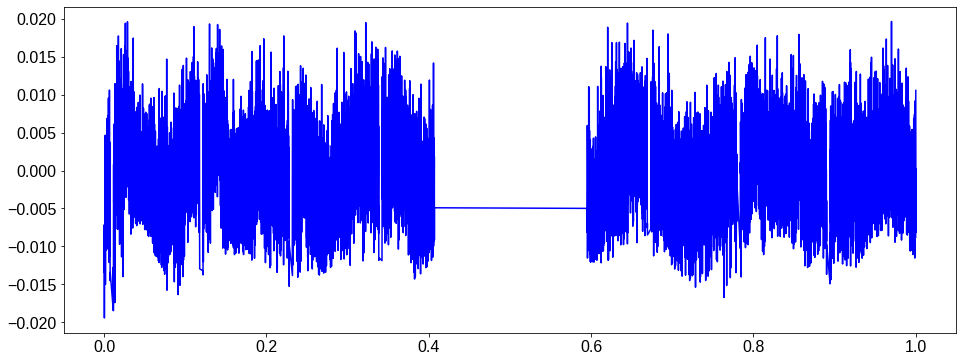

In [13]:
residuals = culled_data[:,1]-baseline
plt.plot(culled_data[:,0], residuals, 'b-')

We now clearly see that trends abound. How would we quantify that? There are two metrics frequently in use: the Durbin-Watson statistic:

$$ d = \frac{\sum_k (r_{k+1}-r_k)^2}{\sum_k r_k^2}, $$

and the Abbe statistic:

$$ \mathcal A = \frac{N}{2(N-1)} \frac{\sum_k (r_{k+1}-r_k)^2}{\sum_k (r_k-\bar r)^2}, $$

where $r$ is the array of the residuals, $N$ is the number of data points, and $\bar r$ is the mean value of the residuals. The value of $d$ is between 0 and 4; if $d$ is close to 2, then there is no significant serial correlation in the residuals; for $d < 2$ we have positive correlation and for $d > 2$ we have negative correlation. For the Abbe value, if $\mathcal A$ is close to 1, there is no significant correlation; for smaller values of $\mathcal A$ there is serial correlation in the residuals.

In [14]:
dw = np.sum((residuals[1:]-residuals[:-1])**2)/np.sum(residuals**2)
print(dw)

1.5743360475893509


In [15]:
abbe = len(residuals)/2/(len(residuals)-1) * np.sum((residuals[1:]-residuals[:-1])**2)/np.sum((residuals-np.mean(residuals))**2)
print(abbe)

0.7872284500100397


This quantification allows us to optimize our detrending parameters; things to try is to optimize the order of the Legendre series and/or sigma-clipping regions, use contiguous subsections of the lightcurve seperately, provide a better baseline model, etc. The approach will ultimately depend on the lightcurve at hand.

# Exercises

* Write a small loop that changes the order of the Legendre series from 20 to 60 and plot $d$ and $\mathcal A$ vs. order.

* Break the timeseries into two parts and fit each part separately. Find a suitable order that flattens the baseline.